In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Apr_weekday_MD.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 0.001114
  (4,4) => 0.0
  (3,1) => 3695.384924
  (4,5) => 0.277368
  (2,4) => 2526.622417
  (6,5) => 1841.708317
  (8,4) => 2373.821136
  (1,2) => 0.0
  (5,1) => 0.006176
  (3,4) => 0.027952
  (8,2) => 0.006854
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 2413.191848
  (2,1) => 1.4e-5
  (2,5) => 0.0
  (8,5) => 0.002083
  (1,4) => 0.0
  (2,8) => 0.0
  (5,8) => 29.798738
  (4,8) => 2353.596482
  (7,8) => 1386.234959
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 50.188476
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Apr_dict = readall("../temp_files/link_day_minute_Apr_dict_JSON.json");
link_day_minute_Apr_dict = replace(link_day_minute_Apr_dict, "NaN", 0);

link_day_minute_Apr_dict = JSON.parse(link_day_minute_Apr_dict);

In [12]:
# week_day_Apr_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30]

# training set 1
week_day_Apr_list_1 = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19]

# training set 2
week_day_Apr_list_2 = [2, 3, 4, 5, 6, 9, 10, 20, 23, 24, 25, 26, 27, 30]

# training set 3
week_day_Apr_list_3 = [11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30]

arcs_1 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
end

In [14]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_2); 
sigma = .0

flow_data_2 = Array(Float64, length(arcs_2[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_2[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
end

In [15]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_3); 
sigma = .0

flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_3[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [16]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [0.001114,0.001114,0.001114,0.001114,0.001114,0.001114,0.001114,0.00…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [3695.384924,3695.384924,3695.384924,3695.384924,3695.384924,3695.38…
  (4,5) => [0.277368,0.277368,0.277368,0.277368,0.277368,0.277368,0.277368,0.27…
  (2,4) => [2526.622417,2526.622417,2526.622417,2526.622417,2526.622417,2526.62…
  (6,5) => [1841.708317,1841.708317,1841.708317,1841.708317,1841.708317,1841.70…
  (8,4) => [2373.821136,2373.821136,2373.821136,2373.821136,2373.821136,2373.82…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [0.006176,0.006176,0.006176,0.006176,0.006176,0.006176,0.006176,0.00…
  (3,4) => [0.027952,0.027952,0.027952,0.027952,0.027952,0.027952,0.027952,0.02…
  (8,2) => [0.006854,0.006854,0.006854,0.006854,0.006854,0.006854,0.006854,0.00…
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (2,6) =>

In [17]:
flow_data_3

24x14 Array{Float64,2}:
 2625.34  2688.9   2665.14  2654.19  …  2747.5   2701.3   2758.07  2630.5 
 2831.2   2915.42  2893.07  2854.34     2924.83  2864.38  2905.74  2832.75
 2377.45  2450.1   2403.14  2514.29     2383.0   2339.85  2393.35  2398.12
 2537.88  2517.27  2491.23  2500.53     2539.65  2526.05  2544.81  2554.77
 2305.36  2351.75  2297.74  2285.24     2320.77  2295.87  2285.57  2236.45
 2467.18  2429.8   2503.14  2339.62  …  2417.59  2409.88  2491.8   2304.41
 2845.52  2910.26  2862.47  2850.96     2894.26  2873.05  2853.67  2861.37
 2889.15  2877.05  2840.77  2846.51     2850.85  2856.42  2815.35  2848.26
 2280.91  2294.36  2230.04  2456.4      2252.89  2219.24  2242.15  2240.74
 2414.92  2384.72  2384.39  2376.03     2394.87  2341.56  2417.37  2374.63
 2139.33  2535.0   2640.14  2757.9   …  2670.13  2639.25  2695.27  2652.08
 2380.7   2365.37  2334.77  2367.4      2392.14  2359.97  2354.26  2385.2 
 2725.57  2809.84  2716.69  2712.87     2765.51  2739.19  2793.85  2732.01
 

In [18]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [0.001114,0.001114,0.001114,0.001114,0.001114,0.001114,0.001114,0.00…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [3695.384924,3695.384924,3695.384924,3695.384924,3695.384924,3695.38…
  (4,5) => [0.277368,0.277368,0.277368,0.277368,0.277368,0.277368,0.277368,0.27…
  (2,4) => [2526.622417,2526.622417,2526.622417,2526.622417,2526.622417,2526.62…
  (6,5) => [1841.708317,1841.708317,1841.708317,1841.708317,1841.708317,1841.70…
  (8,4) => [2373.821136,2373.821136,2373.821136,2373.821136,2373.821136,2373.82…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [0.006176,0.006176,0.006176,0.006176,0.006176,0.006176,0.006176,0.00…
  (3,4) => [0.027952,0.027952,0.027952,0.027952,0.027952,0.027952,0.027952,0.02…
  (8,2) => [0.006854,0.006854,0.006854,0.006854,0.006854,0.006854,0.006854,0.00…
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (2,6) =>

In [19]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [20]:
#include("trafficCval.jl")

coeffs_dict_Apr_MD = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [3:7]
c_grid = 1.:.5:3.
lamb_grid = [10. .^(-5:3)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Apr_MD[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Apr_MD[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Apr_MD[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [25]:
outfile = open("../temp_files/coeffs_dict_Apr_MD.json", "w")

JSON.print(outfile, coeffs_dict_Apr_MD)

close(outfile)

In [26]:
coeffs_dict_Apr_MD_ = readall("../temp_files/coeffs_dict_Apr_MD.json")
coeffs_dict_Apr_MD_ = JSON.parse(coeffs_dict_Apr_MD_)

Dict{String,Any} with 675 entries:
  "(7,2.0,0.1,3)"    => {0.39746776252079313,0.5824171635583982,0.2959502131556…
  "(5,1.0,0.1,1)"    => {0.07663735749960524,0.3189105073047849,0.5303069174948…
  "(6,1.0,1.0,1)"    => {0.044657966756715885,0.22376499298666666,0.46739996226…
  "(3,3.0,0.1,1)"    => {0.5415152589248589,0.4993361693817091,0.15143300588962…
  "(6,2.0,1.0,3)"    => {0.2118044676365617,0.47374506390298793,0.4461685030444…
  "(7,2.0,0.01,3)"   => {0.44953276624988314,0.578961988014135,0.27051190844348…
  "(6,2.0,1000.0,2)" => {0.17769183761473895,0.4454795162092072,0.4657294151014…
  "(3,1.5,0.0001,1)" => {0.02223779827117768,0.8398393064630486,0.4831389812111…
  "(6,2.5,0.0001,3)" => {0.9801222693951211,-0.9849010783827676,0.8403220823612…
  "(6,1.0,0.001,1)"  => {0.09874095915418846,0.45442375353200354,0.721412245193…
  "(6,1.0,0.0001,1)" => {-0.1994886810976584,0.186697482830052,1.43288399969690…
  "(4,3.0,0.0001,3)" => {0.5787647729333931,0.23182325093347272,0.40846954

In [27]:
coeffs_dict_Apr_MD_["(7,1.0,1000.0,1)"]

8-element Array{Any,1}:
 0.026187  
 0.153189  
 0.384354  
 0.536308  
 0.44893   
 0.226286  
 0.0629166 
 0.00765002

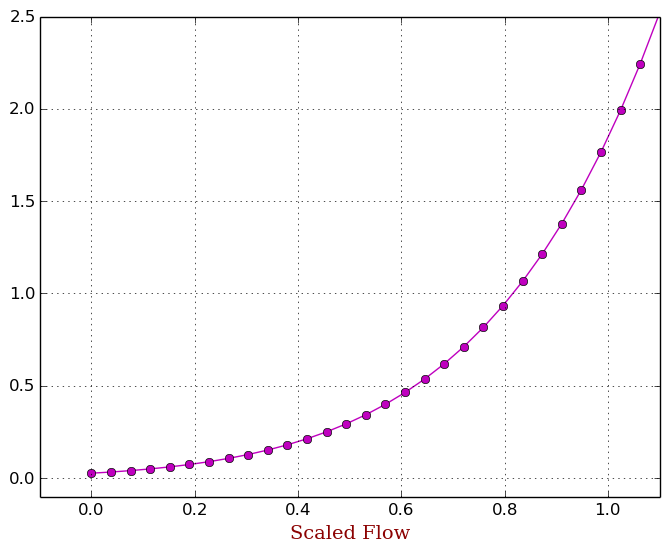

In [28]:
using PyPlot

fcoeffs = coeffs_dict_Apr_MD_["(7,1.0,1000.0,1)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Apr_MD")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.1);
ylim(-0.1, 2.5);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Apr_MD.pdf")